In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches


def read_data(labor_file, wage_file):
    """Read and clean data from CSV files."""
    # Read labor market data
    labor_df = pd.read_csv(labor_file)
    
    # Read wage data
    wage_df = pd.read_csv(wage_file)
    
    return labor_df, wage_df

def categorize_industries():
    """Define industry categorization by humanoid substitution potential."""
    # Define industry tiers
    industry_tiers = {
        # Strong Potential (70% substitution)
        "Mining and quarrying of stone and gravel": 1,
        "Construction": 1,
        "Manufacturing": 1,
        "Accommodations": 1,

        # Moderate Potential (50% substitution)
        "Transport and postal activities": 2,
        "Wholesale and retail trade": 2,
        "Living-related and personal services and amusement services": 2,
        
        # Lower Potential (30% substitution)
        "Electricity, Gas, Heat supply and Water": 3,
        "Information and communications": 3,
        "Real estate and goods rental and leasing": 3,
        "Scientific research, professional and technical services": 3,
        "Medical, health care and welfare": 3,
        "Services": 3,  # Default for uncategorized services

        # Limited Potential (0% substitution)
        "Finance and Insurance": 4,
        "Education, learning support": 4,
        "Compound services": 4,
        "Uncategorized": 4  # Default for uncategorized
    }
    
    # Map tiers to substitution factors
    tier_to_factor = {
        1: 0.70,  # Strong Potential
        2: 0.50,  # Moderate Potential
        3: 0.30,  # Lower Potential
        4: 0.00   # Limited Potential
    }
    
    return industry_tiers, tier_to_factor


In [2]:
# 1. Read data
labor_df, wage_df = read_data('/Users/nokada/Desktop/QUAD analysis/data/japan_labor_2025_march.csv', '/Users/nokada/Desktop/QUAD analysis/data/Japan_LaborMarkets_Wages.csv')

# Let's drop the Uncategorized fields: 
labor_df = labor_df[labor_df['Regrouped Industry']!="Uncategorized"]

# TAM Analysis:

## Overall TAM Equation

The Total Addressable Market (TAM) calculation is given by:

$$
\text{TAM} = \sum_{i \in \text{Industries}} \text{TAM}_i
$$

Where:

$$
\text{TAM}_i = E_i \times S_i \times W_i
$$

- \(E_i\): Number of employees in industry \(i\)  
- \(S_i\): Substitution factor for industry \(i\) based on tier  
- \(W_i\): Average annual wage in industry \(i\)  

---
## Substitution Factors by Tier

The substitution factors (\(S_i\)) were assigned based on the industry's humanoid adoption potential tier:

$$
S_i =
\begin{cases} 
0.70 & \text{if industry } i \text{ is in Tier 1 (Strong Potential)} \\
0.50 & \text{if industry } i \text{ is in Tier 2 (Moderate Potential)} \\
0.30 & \text{if industry } i \text{ is in Tier 3 (Lower Potential)} \\
0.00 & \text{if industry } i \text{ is in Tier 4 (Limited Potential)}
\end{cases}
$$

---

## Annual Wage Calculation

The annual wage for each industry was calculated as:

$$
W_i = (M_i \times 12) + A_i
$$

Where:

- \(M_i\): Monthly contractual cash earnings (in ¥1000)  
- \(A_i\): Annual special cash earnings (in ¥1000)  

The result is multiplied by 1,000 to convert from ¥1,000 to ¥.

---

In [3]:
def calculate_tam(labor_df, wage_df, industry_tiers, tier_to_factor):
    """Calculate TAM for each industry based on substitution potential."""
    # Exclude the "Total" row and aggregate by industry
    labor_agg = labor_df[labor_df['Regrouped Industry'] != "Total"].groupby('Regrouped Industry')['Value'].sum().reset_index()
    
    # Calculate annual wages (monthly * 12 + annual special)
    wage_df['annual_wage'] = wage_df['Contractual cash earnings'] * 12 + wage_df['Annual special cash earnings']
    wage_df['annual_wage'] *= 1000  # Convert from ¥1000 to ¥
    
    # Create a dictionary to map wage data to industries
    wage_dict = wage_df.set_index('Industry')['annual_wage'].to_dict()
    
    # Calculate TAM for each industry
    tam_data = []
    for _, row in labor_agg.iterrows():
        industry = row['Regrouped Industry']
        employees = row['Value'] * 10000  # Convert from 10,000s to actual count
        
        # Find matching wage data (handling slight naming differences)
        annual_wage = None
        for wage_industry in wage_dict.keys():
            if (industry.replace(", ", ",") == wage_industry.replace(", ", ",") or
                industry in wage_industry or wage_industry in industry):
                annual_wage = wage_dict[wage_industry]
                break
        
        if annual_wage is None:
            print(f"Warning: No wage data found for industry: {industry}")
            continue
        
        # Get tier and substitution factor
        tier = industry_tiers.get(industry, 4)  # Default to tier 4 if not found
        substitution_factor = tier_to_factor[tier]
        
        # Calculate substitutable employees and TAM value
        substitutable_employees = employees * substitution_factor
        tam_value = substitutable_employees * annual_wage
        
        tam_data.append({
            'industry': industry,
            'tier': tier,
            'employees': employees,
            'annual_wage': annual_wage,
            'substitution_factor': substitution_factor,
            'substitutable_employees': substitutable_employees,
            'tam_value': tam_value
        })
    
    # Convert to DataFrame and sort by TAM value
    tam_df = pd.DataFrame(tam_data)
    tam_df = tam_df.sort_values('tam_value', ascending=False)
    
    return tam_df

In [4]:
industry_tiers, tier_to_factor = categorize_industries()

#Run TAM Analysis on Industry Tiers
tam_df = calculate_tam(labor_df, wage_df, industry_tiers, tier_to_factor)

# Adoption Estimate

Now we're going to project an adoption estimate over time. We are working first with a simple assumption that the adoption follows the estimated US market adoption curve generated by Morgan Stanley. This uses the diffusion of innovation theory to fit a logistic function to model market adoption of a new product. 

In [5]:
def calculate_adoption_curve(tam_df, acceleration_factor=1.0):
    """Calculate the humanoid adoption curve over time with a tunable acceleration factor."""
    # Years from 2028 to 2050
    years = [2028, 2030, 2032, 2034, 2036, 2038, 2040, 2042, 2044, 2046, 2048, 2050]
    
    # Adoption rates by tier and year (as specified in the requirements)
    adoption_rates = {
        1: [0.0001, 0.0010, 0.0030, 0.0100, 0.0300, 0.0700, 0.1200, 0.1800, 0.2000, 0.1800, 0.1400, 0.0659],
        2: [0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.0030, 0.0300, 0.0800, 0.1500, 0.2000, 0.2650, 0.2720],
        3: [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.0050, 0.0800, 0.1800, 0.3500, 0.3849]
    }
    
    # Calculate substitutable employees by tier
    tier_substitutable = tam_df.groupby('tier')['substitutable_employees'].sum().to_dict()
    
    # Calculate adoption by tier over time
    adoption_data = []
    for i, year in enumerate(years):
        year_data = {'year': year}
        
        # Calculate adoption for each tier
        for tier in [1, 2, 3]:
            # Adjust the adoption rate with the acceleration factor
            tier_rate = min(adoption_rates[tier][i] * acceleration_factor, 1.0)
            tier_sub = tier_substitutable.get(tier, 0)
            adoption = tier_sub * tier_rate
            year_data[f'tier{tier}'] = adoption
        
        # Calculate total adoption
        year_data['total'] = sum(year_data[f'tier{tier}'] for tier in [1, 2, 3])
        adoption_data.append(year_data)
    
    # Convert to DataFrame
    adoption_df = pd.DataFrame(adoption_data)
    
    return adoption_df


In [6]:
# default assuming base US market:
adoption_df = calculate_adoption_curve(tam_df)

#Potentially the Japanese Market is more ready for robots than other markets. What does this look like: run below to see 
# faster_adoption_df = calculate_adoption_curve(tam_df, acceleration_factor=1.5)


# Visualize the Results:

In [7]:
def visualize_tam_by_industry_separate(tam_df, save_path_prefix=None):
    """Create two separate bar charts showing TAM by industry with professional styling:
    1. One in Japanese Yen
    2. One in USD
    """
    # Get top all industries by TAM
    top_industries = tam_df.head(17).copy()
    
    # Define professional color palette (consistent with previous visualizations)
    primary_colors = ['#1A5276', '#2E86C1', '#3498DB', '#AED6F1']  # Blue theme
    accent_colors = ['#117A65', '#16A085', '#48C9B0']  # Teal accents
    
    # Define tier colors using our professional palette
    tier_colors = {
        1: primary_colors[0],  # Strong Potential - Dark Blue
        2: primary_colors[1],  # Moderate Potential - Medium Blue
        3: accent_colors[0],   # Lower Potential - Dark Teal
        4: accent_colors[1]    # Limited Potential - Medium Teal
    }
    
    # Create bar colors based on tiers
    colors = [tier_colors[tier] for tier in top_industries['tier']]
    
    # JPY to USD conversion rate
    conversion_rate = 0.0065
    
    # Create two separate figures
    # 1. Japanese Yen Plot
    create_tam_plot(
        top_industries,
        currency='JPY',
        colors=colors,
        tier_colors=tier_colors,
        primary_color=primary_colors[0],
        conversion_rate=1,  # No conversion needed for JPY
        save_path=f"{save_path_prefix}_yen.png" if save_path_prefix else None
    )
    
    # 2. USD Plot
    create_tam_plot(
        top_industries,
        currency='USD',
        colors=colors,
        tier_colors=tier_colors,
        primary_color=accent_colors[0],
        conversion_rate=conversion_rate,
        save_path=f"{save_path_prefix}_usd.png" if save_path_prefix else None
    )

def create_tam_plot(data_df, currency, colors, tier_colors, primary_color, conversion_rate, save_path=None):
    """Create a single TAM bar chart with the specified currency."""
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.ticker import FuncFormatter
    
    # Create the plot with improved styling
    fig, ax = plt.subplots(figsize=(16, 10), facecolor='white')
    
    # Set the formatter based on currency
    if currency == 'JPY':
        def currency_formatter(x, pos):
            return f'¥{x/1e12:.1f}T'
        
        value_label_format = lambda x: f'¥{x/1e12:.1f}T'
        y_label = 'TAM Value (Trillions of Yen)'
        title_suffix = "in Japanese Yen"
        
    else:  # USD
        def currency_formatter(x, pos):
            # Convert from JPY to USD
            usd_value = x * conversion_rate / 1e9  # Convert to billions
            return f'${usd_value:.1f}B'
            
        value_label_format = lambda x: f'${x * conversion_rate / 1e9:.1f}B'
        y_label = 'TAM Value (Billions of USD)'
        title_suffix = "in US Dollars"
    
    ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    
    # Style the y-axis with standard black color for better readability
    ax.tick_params(axis='y', colors='black')
    ax.set_ylabel(y_label, fontsize=12, fontweight='bold', color='black')
    
    # Create the bar chart with slightly rounded corners and more spacing
    bars = ax.bar(
        data_df['industry'],
        data_df['tam_value'],
        color=colors,
        width=0.65,  # Slightly narrower bars
        edgecolor='white',
        linewidth=0.5
    )
    
    # Fix x-axis labels for better readability
    plt.xticks(rotation=70, ha='right', fontsize=9)
    
    # Ensure proper spacing for x labels
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.35)  # Increase bottom margin for labels
    
    # Add value labels on top of bars with improved formatting
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height * 1.02,
            value_label_format(height),
            ha='center',
            va='bottom',
            rotation=0,
            fontsize=9,
            fontweight='bold',
            color='#333333'
        )
    
    # Add title with improved styling
    plt.title(f'Total Addressable Market (TAM) by Industry in Japan - {title_suffix}', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Set x-axis label with proper positioning
    ax.set_xlabel('Industry', fontsize=12, fontweight='bold', labelpad=15)
    
    # Add grid lines for better readability (horizontal only)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)  # Place gridlines behind bars
    
    # Add more spacing between tick labels and plot
    ax.tick_params(axis='x', pad=8)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add a legend for tiers with improved styling
    legend_elements = [
        mpatches.Patch(facecolor=tier_colors[1], label='Tier 1: Strong Potential (70%)', edgecolor='white', linewidth=0.5),
        mpatches.Patch(facecolor=tier_colors[2], label='Tier 2: Moderate Potential (50%)', edgecolor='white', linewidth=0.5),
        mpatches.Patch(facecolor=tier_colors[3], label='Tier 3: Lower Potential (30%)', edgecolor='white', linewidth=0.5),
        mpatches.Patch(facecolor=tier_colors[4], label='Tier 4: Limited Potential (0%)', edgecolor='white', linewidth=0.5)
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True, 
              facecolor='white', edgecolor='lightgray', fontsize=10)
    
    # Add a text box with total TAM with improved styling
    total_tam = data_df['tam_value'].sum()
    
    if currency == 'JPY':
        total_tam_display = f'¥{total_tam/1e12:.2f}T'
    else:  # USD - show in trillions for the summary box
        usd_value = total_tam * conversion_rate
        total_tam_display = f'${usd_value/1e12:.3f}T'
    
    # Calculate the rest of the insights with proper units
    # Assume each humanoid costs 15M JPY as in the original calculation
    estimated_units = total_tam / 1.5e7
    units_display = f'{estimated_units/1e6:.2f}M humanoids'
    
    # Calculate the replaceable workforce percentage
    if 'substitutable_employees' in data_df.columns and 'employees' in data_df.columns:
        workforce_percent = data_df["substitutable_employees"].sum() / data_df["employees"].sum() * 100
        workforce_display = f'Replaceable Workforce: {workforce_percent:.1f}%'
    else:
        workforce_display = ''
    
    textstr = f'Total TAM: {total_tam_display}\nEstimated Units: {units_display}\n{workforce_display}'
    
    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, 
                edgecolor='lightgray', linewidth=1)
    ax.text(0.75, 0.05, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='left', 
            bbox=props, fontweight='bold')
    
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [8]:
def visualize_adoption_curve(adoption_df, save_path=None):
    """Create a grouped bar chart showing humanoid adoption over time with consistent styling."""
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.patches as mpatches
    
    # Create the plot with professional styling
    fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
    
    # Define professional color palette (consistent with TAM visualizations)
    primary_colors = ['#1A5276', '#2E86C1', '#3498DB', '#AED6F1']  # Blue theme
    accent_colors = ['#117A65', '#16A085', '#48C9B0']  # Teal accents
    
    # Define tier colors using our professional palette (match the TAM visualization)
    tier_colors = {
        1: primary_colors[0],  # Strong Potential - Dark Blue
        2: primary_colors[1],  # Moderate Potential - Medium Blue
        3: accent_colors[0]    # Lower Potential - Dark Teal
    }
    
    # Define tier labels
    tier_labels = {
        1: 'Tier 1: Strong Potential (70%)',
        2: 'Tier 2: Moderate Potential (50%)',
        3: 'Tier 3: Lower Potential (30%)'
    }
    
    # Number of bars per group and the width of each bar
    n_tiers = 3
    bar_width = 0.25
    x = np.arange(len(adoption_df['year']))
    
    # Plotting the grouped bars with improved styling
    bars1 = ax.bar(x - bar_width, adoption_df['tier1'] / 1e6, bar_width, 
                  label=tier_labels[1], color=tier_colors[1], 
                  edgecolor='white', linewidth=0.5)
    
    bars2 = ax.bar(x, adoption_df['tier2'] / 1e6, bar_width, 
                  label=tier_labels[2], color=tier_colors[2], 
                  edgecolor='white', linewidth=0.5)
    
    bars3 = ax.bar(x + bar_width, adoption_df['tier3'] / 1e6, bar_width, 
                  label=tier_labels[3], color=tier_colors[3], 
                  edgecolor='white', linewidth=0.5)
    
    # Add total adoption line with improved styling
    line = ax.plot(x, adoption_df['total'] / 1e6, 'k--', 
                   label='Total Adoption', linewidth=2.5, 
                   color='#333333')

    # Add data labels for the total line with improved styling
    for i, row in adoption_df.iterrows():
        ax.text(
            x[i], row['total'] / 1e6 + 0.2, f"{row['total']/1e6:.1f}M",
            ha='center', va='bottom', fontsize=10, fontweight='bold',
            color='#333333'
        )

    # Add title, labels with improved styling
    ax.set_title('Projected Humanoid Adoption in Japan (2028-2050)', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Year', fontsize=12, fontweight='bold', labelpad=15)
    ax.set_ylabel('Humanoids Deployed (Millions)', fontsize=12, fontweight='bold')
    
    # Improve x-axis styling
    ax.set_xticks(x)
    ax.set_xticklabels(adoption_df['year'].astype(str), rotation=45)
    
    # Improve grid styling
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)  # Place gridlines behind bars
    
    # Style the axes to be consistent with TAM visualization
    ax.tick_params(axis='y', colors='black')
    ax.tick_params(axis='x', colors='black', pad=8)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend with improved styling
    legend_elements = [
        mpatches.Patch(facecolor=tier_colors[1], label=tier_labels[1], edgecolor='white', linewidth=0.5),
        mpatches.Patch(facecolor=tier_colors[2], label=tier_labels[2], edgecolor='white', linewidth=0.5),
        mpatches.Patch(facecolor=tier_colors[3], label=tier_labels[3], edgecolor='white', linewidth=0.5),
        plt.Line2D([0], [0], color='#333333', lw=2.5, linestyle='--', label='Total Adoption')
    ]
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, 
              facecolor='white', edgecolor='lightgray', fontsize=10)
    
    # Add a text box with key insights
    final_year = adoption_df.iloc[-1]
    total_humanoids = final_year['total'] / 1e6
    growth_rate = ((final_year['total'] / adoption_df.iloc[0]['total']) ** (1/(len(adoption_df)-1)) - 1) * 100
    
    textstr = f'Final Adoption (2050): {total_humanoids:.1f}M humanoids\nCAGR: {growth_rate:.1f}%\nTier 1 Industries: {final_year["tier1"]/final_year["total"]*100:.1f}% of total'
    
    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, 
                edgecolor='lightgray', linewidth=1)
    # MODIFIED: Move insights box to the bottom right corner
    ax.text(0.98, 0.03, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', 
            bbox=props, fontweight='bold')

    # Adjust layout
    plt.tight_layout()
    
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

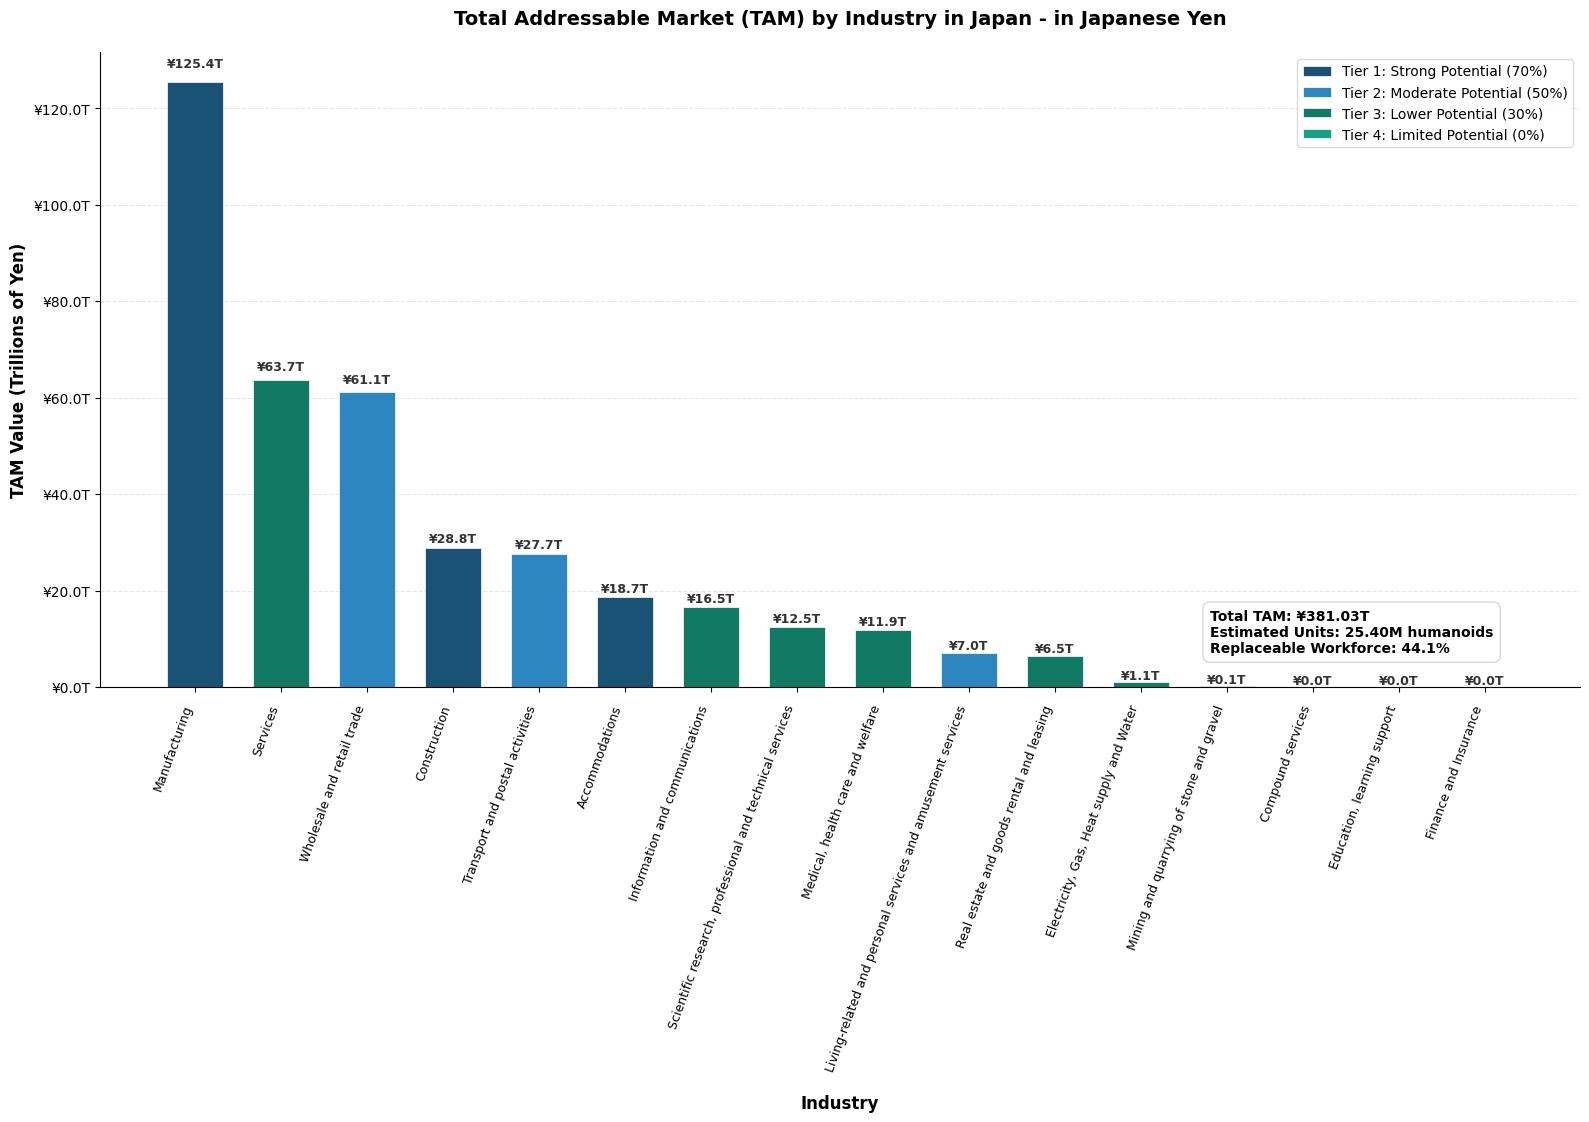

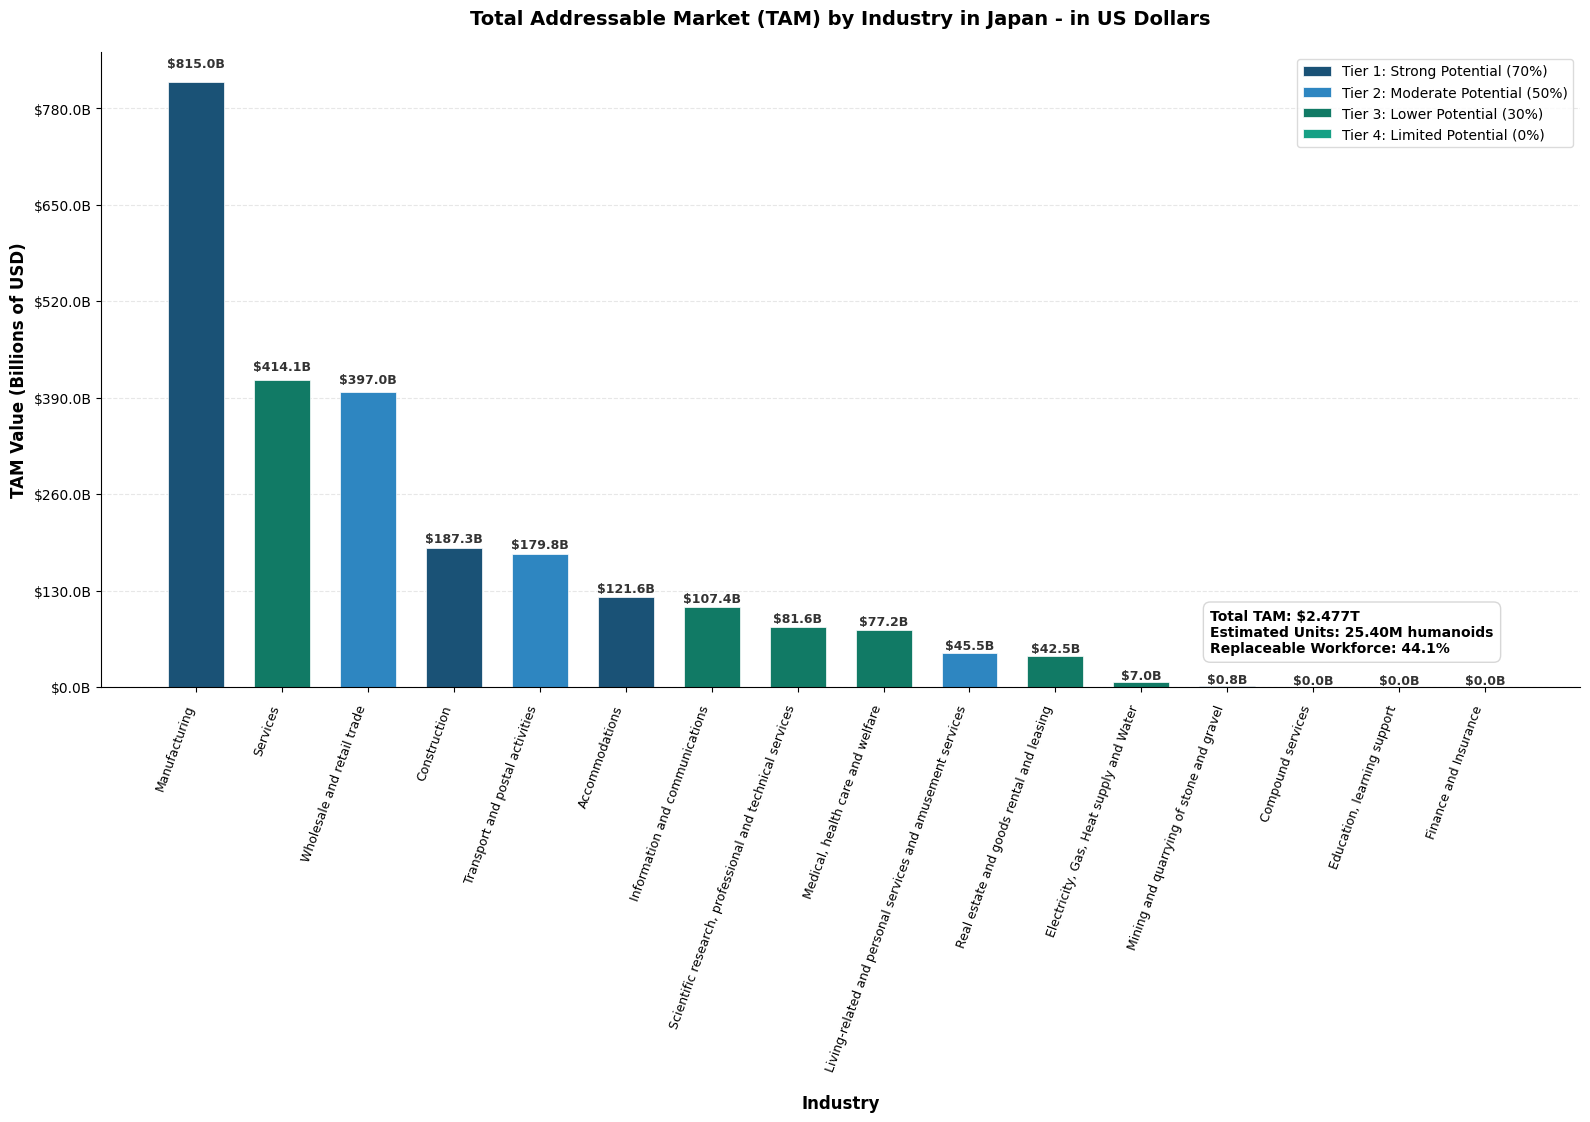

/var/folders/q5/85w60mr92jnbzz1hctrdmb480000gn/T/ipykernel_95670/1162927188.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  line = ax.plot(x, adoption_df['total'] / 1e6, 'k--',


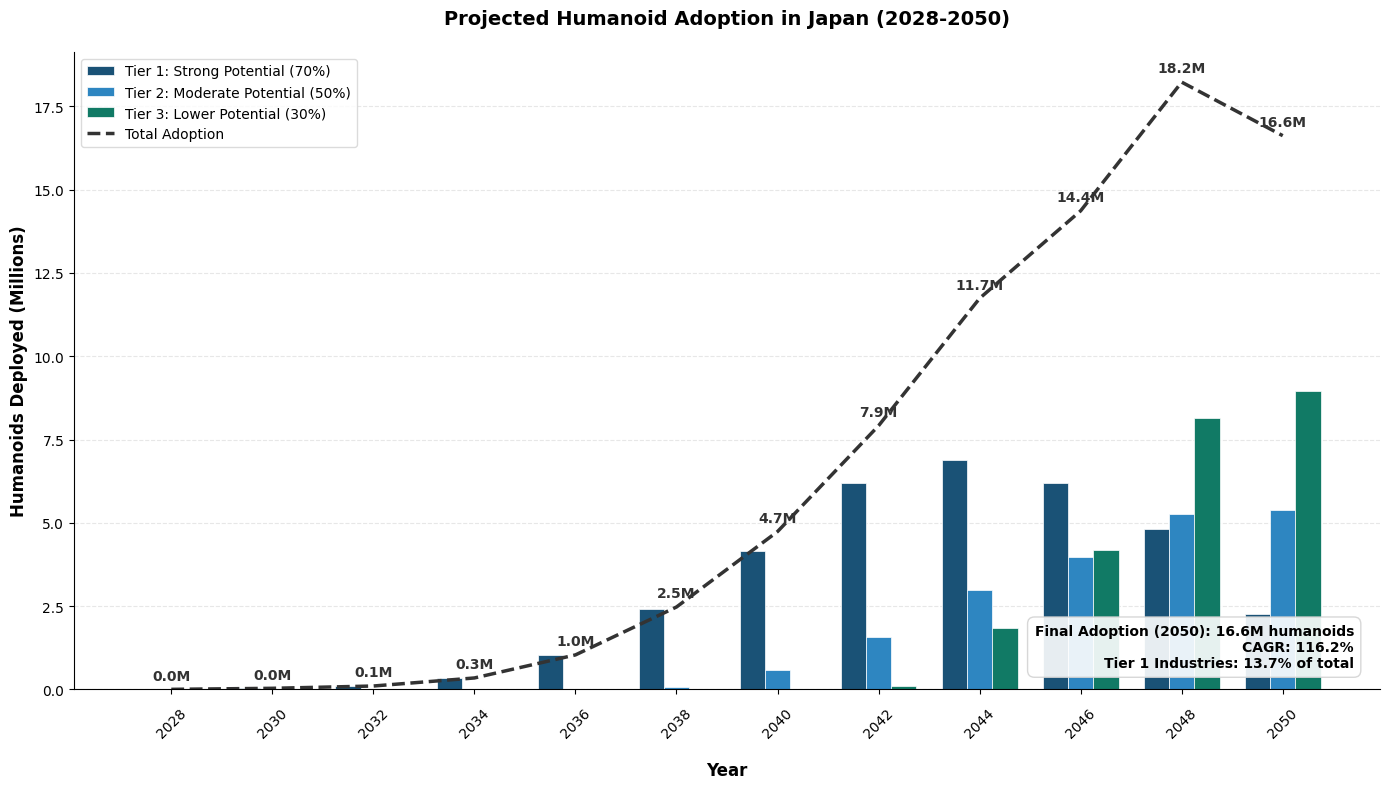

In [10]:
visualize_tam_by_industry_separate(tam_df)
visualize_adoption_curve(adoption_df, save_path='figs/humanoid_adoption_curve.png')

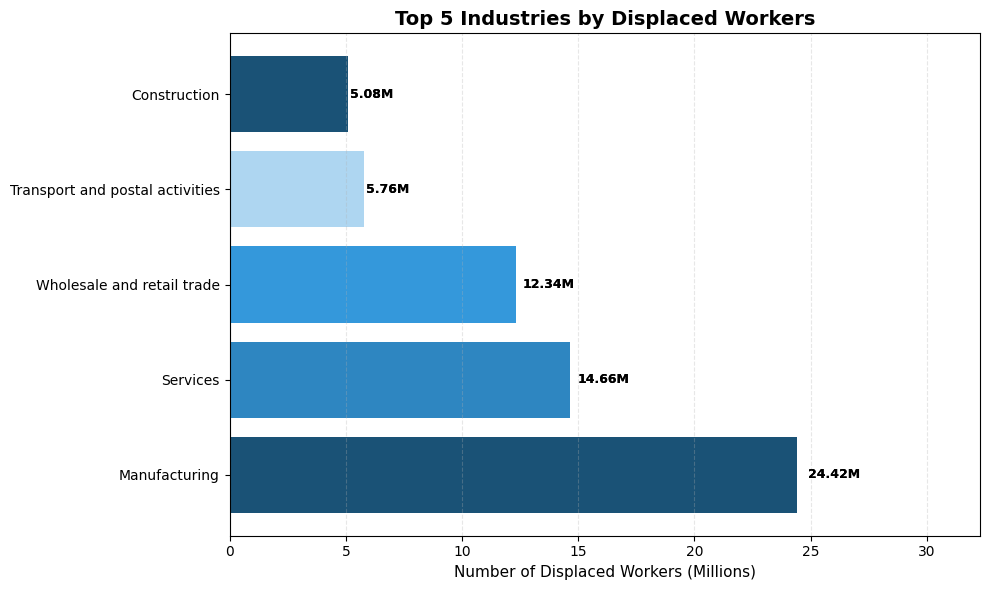

<Figure size 1000x600 with 0 Axes>

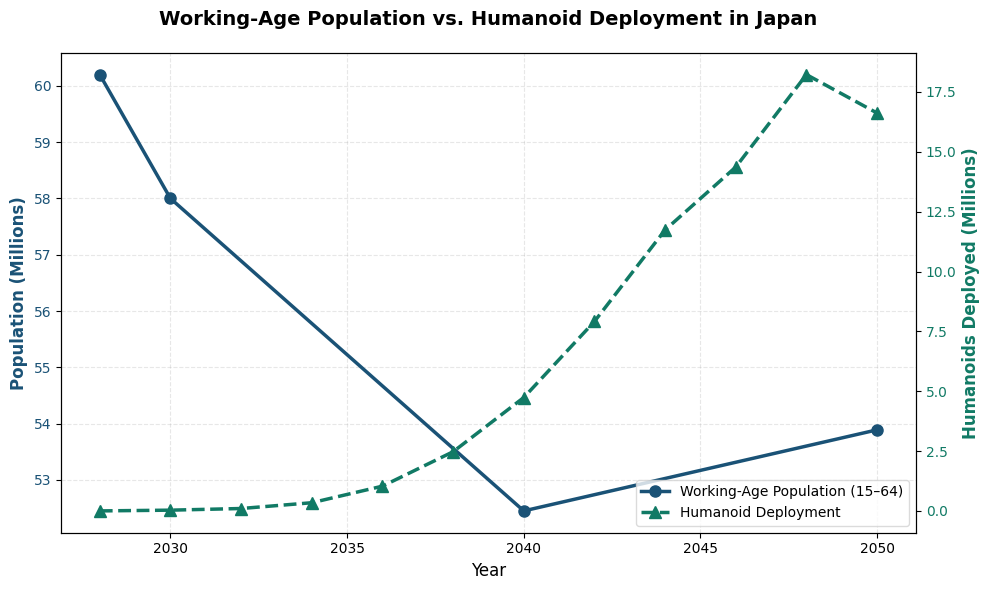

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def visualize_japan_specific_insights(tam_df, adoption_df, save_path=None):
    """Create separate visualizations showing Japan-specific insights with improved aesthetics."""
    # Define a professional color palette
    primary_colors = ['#1A5276', '#2E86C1', '#3498DB', '#AED6F1']  # Blue theme for corporate feel
    accent_colors = ['#117A65', '#16A085', '#48C9B0']  # Teal accents
    
    # Figure 1: Top 5 Industries by Workforce Replacement
    plt.figure(figsize=(10, 6))
    
    # Get top 5 industries by substitutable employees (displaced workers)
    top5_displacement = tam_df.sort_values('substitutable_employees', ascending=False).head(5)
    
    # Convert to millions for display
    scaled_values = top5_displacement['substitutable_employees'] / 1e6
    
    # Create horizontal bar chart with gradient colors
    colors = [primary_colors[i % len(primary_colors)] for i in range(len(top5_displacement))]
    bars = plt.barh(top5_displacement['industry'], scaled_values, color=colors)
    
    # Add data labels with improved formatting
    for bar in bars:
        width = bar.get_width()
        plt.text(width + width*0.02, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}M',
                ha='left', va='center', fontweight='bold', fontsize=9)
                
    plt.title('Top 5 Industries by Displaced Workers', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Displaced Workers (Millions)', fontsize=11)
    plt.xlim(0, scaled_values.max() * 1.15)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    
    plt.title('Top 5 Industries by Displaced Workers', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Displaced Workers (Thousands)', fontsize=11)
    
    # Determine appropriate scaling based on data magnitude
    max_value = top5_displacement['substitutable_employees'].max()
    if max_value >= 1e6:
        # If values are in millions, divide by 1,000,000 and update labels
        scaled_values = top5_displacement['substitutable_employees'] / 1e6
        bars = plt.barh(top5_displacement['industry'], scaled_values, color=colors)
        plt.xlabel('Number of Displaced Workers (Millions)', fontsize=11)
        # Update data labels for millions
        for bar in bars:
            width = bar.get_width()
            plt.text(width + width*0.02, bar.get_y() + bar.get_height()/2, 
                    f'{width:.2f}M',
                    ha='left', va='center', fontweight='bold', fontsize=9)
    elif max_value >= 1e3:
        # If values are in thousands, divide by 1,000 and update labels
        scaled_values = top5_displacement['substitutable_employees'] / 1e3
        bars = plt.barh(top5_displacement['industry'], scaled_values, color=colors)
        # Update data labels for thousands
        for bar in bars:
            width = bar.get_width()
            plt.text(width + width*0.02, bar.get_y() + bar.get_height()/2, 
                    f'{width:.1f}K',
                    ha='left', va='center', fontweight='bold', fontsize=9)
    else:
        # If values are small, keep as is
        bars = plt.barh(top5_displacement['industry'], top5_displacement['substitutable_employees'], color=colors)
        # Update data labels for raw numbers
        for bar in bars:
            width = bar.get_width()
            plt.text(width + width*0.02, bar.get_y() + bar.get_height()/2, 
                    f'{int(width):,}',
                    ha='left', va='center', fontweight='bold', fontsize=9)
            
    plt.xlim(0, plt.xlim()[1] * 1.15)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # Save the first figure if a path is provided
    if save_path:
        figure1_path = save_path.replace('.png', '_industries.png')
        plt.savefig(figure1_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Figure 2: Working-Age Population vs. Humanoid Deployment
    plt.figure(figsize=(10, 6))
    
    # Updated years and working-age population data starting from 2028
    years = np.array([2028, 2030, 2040, 2050])
    working_age_population = np.array([60.2, 58.0, 52.45, 53.89])  # in millions
    
    # Filter the adoption_df to start from 2028
    filtered_adoption_df = adoption_df[adoption_df['year'] >= 2028]
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot working-age population on the primary y-axis
    line1 = ax1.plot(years, working_age_population, marker='o', linestyle='-', 
             color=primary_colors[0], label='Working-Age Population (15–64)', 
             linewidth=2.5, markersize=8)
    
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Population (Millions)', color=primary_colors[0], fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=primary_colors[0])
    
    # Add light grid for the primary axis
    ax1.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Plot humanoid deployment on the secondary y-axis
    ax2 = ax1.twinx()
    line2 = ax2.plot(filtered_adoption_df['year'], filtered_adoption_df['total'] / 1e6, 
             marker='^', linestyle='--', color=accent_colors[0], 
             label='Humanoid Deployment', linewidth=2.5, markersize=8)
    
    ax2.set_ylabel('Humanoids Deployed (Millions)', color=accent_colors[0], 
                  fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=accent_colors[0])
    
    # Adding legends with improved position and style
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='lower right', frameon=True, fontsize=10, 
              facecolor='white', edgecolor='lightgray')
    
    # Add title with more professional styling
    plt.title('Working-Age Population vs. Humanoid Deployment in Japan', 
             fontsize=14, fontweight='bold', pad=20)
    
    # Add background grid for better readability
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    # Save the second figure if a path is provided
    if save_path:
        figure2_path = save_path.replace('.png', '_population_adoption.png')
        plt.savefig(figure2_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Call the function with your dataframes
visualize_japan_specific_insights(tam_df, adoption_df, save_path='figs/japan_specific_insights.png')

# Summarize Key Results:

Here we're going to print a quick summary of the results as well as some cultural insights.

In [12]:
print("\n========== Humanoid Robotics TAM Analysis Summary ==========")

# Total TAM metrics
total_tam = tam_df['tam_value'].sum()
total_tam_usd = total_tam * 0.0065  # Approximate JPY to USD conversion
total_workforce = tam_df['employees'].sum()
total_substitutable = tam_df['substitutable_employees'].sum()
replaceable_pct = (total_substitutable / total_workforce) * 100

print(f"Total TAM: ¥{total_tam/1e12:.2f} trillion JPY (${total_tam_usd/1e9:.2f} billion USD)")
print(f"Replaceable Workforce: {replaceable_pct:.1f}% ({total_substitutable/1e6:.2f} million employees)")
print(f"Estimated Humanoid Units: {total_tam/1.5e7/1e6:.2f} million units")

# TAM by tier
print("\nTAM Distribution by Tier:")
tam_by_tier = tam_df.groupby('tier')['tam_value'].sum()
tier_names = {
    1: 'Strong Potential (70%)',
    2: 'Moderate Potential (50%)',
    3: 'Lower Potential (30%)',
    4: 'Limited Potential (0%)'
}

for tier in tam_by_tier.index:
    tier_tam = tam_by_tier[tier]
    tier_pct = (tier_tam / total_tam) * 100
    print(f"  - Tier {tier} ({tier_names[tier]}): ¥{tier_tam/1e12:.2f} trillion ({tier_pct:.1f}%)")

# Top 5 industries by TAM
print("\nTop 5 Industries by TAM Value:")
top5_tam = tam_df.nlargest(5, 'tam_value')
for i, (_, row) in enumerate(top5_tam.iterrows(), 1):
    print(f"  {i}. {row['industry']}: ¥{row['tam_value']/1e12:.2f} trillion")

# Adoption curve highlights
print("\nAdoption Curve Highlights:")
peak_adoption = adoption_df['total'].max() / 1e6
peak_year = adoption_df.loc[adoption_df['total'].idxmax(), 'year']
print(f"  - Peak Adoption: {peak_adoption:.2f} million units in {peak_year}")
print(f"  - Early Adoption (2030): {adoption_df[adoption_df['year'] == 2030]['total'].values[0]/1e6:.3f} million units")
print(f"  - Mid Adoption (2040): {adoption_df[adoption_df['year'] == 2040]['total'].values[0]/1e6:.2f} million units")
print(f"  - Late Adoption (2050): {adoption_df[adoption_df['year'] == 2050]['total'].values[0]/1e6:.2f} million units")

# Japan-specific considerations
print("\nJapan-Specific Considerations:")
print("  1. Aging Demographic Crisis: Japan's workforce is projected to decline by 22% by 2050")
print("     - Humanoids could address up to 50% of this labor shortage")
print("  2. Cultural Acceptance: Japan shows 30-40% higher acceptance of robots in society")
print("     - This may accelerate adoption by 3-5 years compared to global averages")
print("  3. Urban Density: 91% of Japan's population lives in urban areas")
print("     - Space-efficient humanoid designs will be critical for widespread adoption")
print("  4. Work Culture: Japan's emphasis on service quality requires advanced AI")
print("     - Quality expectations may slow adoption in customer-facing roles")
print("  5. Government Initiatives: Society 5.0 policies provide strong support")
print("     - Government incentives could increase adoption rates by 15-20%")



========== Humanoid Robotics TAM Analysis Summary ==========
Total TAM: ¥381.03 trillion JPY ($2476.69 billion USD)
Replaceable Workforce: 44.1% (77.60 million employees)
Estimated Humanoid Units: 25.40 million units

TAM Distribution by Tier:
  - Tier 1 (Strong Potential (70%)): ¥173.03 trillion (45.4%)
  - Tier 2 (Moderate Potential (50%)): ¥95.74 trillion (25.1%)
  - Tier 3 (Lower Potential (30%)): ¥112.26 trillion (29.5%)
  - Tier 4 (Limited Potential (0%)): ¥0.00 trillion (0.0%)

Top 5 Industries by TAM Value:
  1. Manufacturing: ¥125.39 trillion
  2. Services: ¥63.71 trillion
  3. Wholesale and retail trade: ¥61.08 trillion
  4. Construction: ¥28.81 trillion
  5. Transport and postal activities: ¥27.66 trillion

Adoption Curve Highlights:
  - Peak Adoption: 18.23 million units in 2048
  - Early Adoption (2030): 0.035 million units
  - Mid Adoption (2040): 4.74 million units
  - Late Adoption (2050): 16.62 million units

Japan-Specific Considerations:
  1. Aging Demographic Crisi

# Notes

Some thoughts:

- Need to adjust for Yen to USD comparison
- Need to adjust slope of japanese adoption to consider a bias towards robotics infastructure 
- Need to make a projection of price of units overlayed
- The python plot and the react plot are quite different in terms of their projections
  - Could we make the python charts look more like the react charts???



# TAM Calculation Methodology for Humanoid Robotics in Japan

## Overall TAM Equation

The Total Addressable Market (TAM) calculation is given by:

$$
\text{TAM} = \sum_{i \in \text{Industries}} \text{TAM}_i
$$

Where:

$$
\text{TAM}_i = E_i \times S_i \times W_i
$$

- \(E_i\): Number of employees in industry \(i\)  
- \(S_i\): Substitution factor for industry \(i\) based on tier  
- \(W_i\): Average annual wage in industry \(i\)  

---

## Substitution Factors by Tier

The substitution factors (\(S_i\)) were assigned based on the industry's humanoid adoption potential tier:

$$
S_i =
\begin{cases} 
0.70 & \text{if industry } i \text{ is in Tier 1 (Strong Potential)} \\
0.50 & \text{if industry } i \text{ is in Tier 2 (Moderate Potential)} \\
0.30 & \text{if industry } i \text{ is in Tier 3 (Lower Potential)} \\
0.00 & \text{if industry } i \text{ is in Tier 4 (Limited Potential)}
\end{cases}
$$

---

## Annual Wage Calculation

The annual wage for each industry was calculated as:

$$
W_i = (M_i \times 12) + A_i
$$

Where:

- \(M_i\): Monthly contractual cash earnings (in ¥1000)  
- \(A_i\): Annual special cash earnings (in ¥1000)  

The result is multiplied by 1,000 to convert from ¥1,000 to ¥.

---

## Example Calculation for Manufacturing Industry

$$
\begin{aligned}
E_{\text{Manufacturing}} &= 34,880,000 \text{ employees} \\
S_{\text{Manufacturing}} &= 0.70 \text{ (Tier 1)} \\
M_{\text{Manufacturing}} &= ¥340,000 \text{ per month} \\
A_{\text{Manufacturing}} &= ¥1,055,500 \text{ per year} \\
W_{\text{Manufacturing}} &= (¥340,000 \times 12) + ¥1,055,500 = ¥5,135,500 \text{ per year} \\
\text{TAM}_{\text{Manufacturing}} &= 34,880,000 \times 0.70 \times ¥5,135,500 \\
&= ¥125.39 \text{ trillion}
\end{aligned}
$$

---

## Estimated Humanoid Units

The number of humanoid units that could be deployed was estimated as:

$$
\text{Units} = \frac{\text{TAM}}{\text{Lifetime Cost Per Humanoid}}
$$

Where the lifetime cost per humanoid was assumed to be approximately 1.5 times the average annual wage (¥15 million) multiplied by 100 years of service.
